In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

In [4]:
# Check for daylight saving time issues
data = pd.read_excel('System_Data_Qtr_Hourly_2024.xlsx')
data.head()
# Check for daylight saving time issues
data['DateTime'] = pd.to_datetime(data['DateTime'])
data = data.sort_values('DateTime')

# Compute time differences
diff = data['DateTime'].diff()

# Detect 1-hour jumps
one_hour_diff = pd.Timedelta(hours=1)
dst_issues = data[diff == one_hour_diff]

print("DST-related 1-hour jumps found:", len(dst_issues))
dst_issues.head()

data['DateTime'] = pd.to_datetime(data['DateTime'])
data = data.sort_values('DateTime')

# Compute time differences
diff = data['DateTime'].diff()

# Detect 1-hour jumps
one_hour_diff = pd.Timedelta(hours=1)
dst_issues = data[diff == one_hour_diff]

print("DST-related 1-hour jumps found:", len(dst_issues))
dst_issues.head()

# Duplicates and missing timestamps

# datetime and sorted order
data['DateTime'] = pd.to_datetime(data['DateTime'], errors='coerce')
data = data.sort_values('DateTime').reset_index(drop=True)

# Expected time frequency
expected_freq = '15min'
expected_timedelta = pd.Timedelta(expected_freq)

# Check for duplicates
duplicates_mask = data['DateTime'].duplicated(keep=False)
duplicates = data[data['DateTime'].duplicated(keep='first')]
print("Duplicate timestamps:", len(duplicates))


# Check for missing timestamps
full_range = pd.date_range(start=data['DateTime'].min(),end=data['DateTime'].max(),freq=expected_freq)
missing = full_range.difference(data['DateTime'])
print("Missing timestamps:", len(missing))

# Convert DateTime to index before grouping
data['DateTime'] = pd.to_datetime(data['DateTime'], errors='coerce')
data = data.sort_values('DateTime')

# Set as index
data = data.set_index('DateTime')

# Group by DateTime to consolidate duplicates & average numeric columns
data = data.groupby(level=0).mean()

# Ensure continuity
data = data.asfreq('15min')

# Time interpolation preserves shape and trends
data = data.interpolate(method='time')

print("Remaining duplicates:", data.index.duplicated().sum())

expected = pd.date_range(data.index.min(), data.index.max(), freq="15min")
missing = expected.difference(data.index)
print("Remaining missing timestamps:", len(missing))

print("Final frequency inferred:", data.index.inferred_freq)

data['Hour'] = data.index.hour
data['Day'] = data.index.day
data['Month'] = data.index.month

data['Season'] = data['Month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
})
data.head()


DST-related 1-hour jumps found: 0
DST-related 1-hour jumps found: 0
Duplicate timestamps: 4
Missing timestamps: 4
Remaining duplicates: 0
Remaining missing timestamps: 0
Final frequency inferred: 15min


GMT Offset  NI Generation  NI Demand  NI Wind Generation  \
DateTime                                                                        
2024-01-01 00:00:00         0.0        715.613    584.635             249.907   
2024-01-01 00:15:00         0.0        702.913    570.701             216.946   
2024-01-01 00:30:00         0.0        799.801    563.575             301.445   
2024-01-01 00:45:00         0.0        877.653    562.830             376.547   
2024-01-01 01:00:00         0.0        872.636    577.349             378.713   

                     NI Solar Generation  IE Generation  IE Demand  \
DateTime                                                             
2024-01-01 00:00:00                  0.0        3123.41    3462.62   
2024-01-01 00:15:00                  0.0        3127.56    3427.96   
2024-01-01 00:30:00                  0.0        3138.09    3394.02   
2024-01-01 00:45:00                  0.0        3112.86    3364.86   
2024-01-01 01:00:00                  0.0        3042.50    3333.30   

                     IE Wind Generation  IE Solar Generation  Hour  Day  \
DateTime                                                                  
2024-01-01 00:00:00             2244.60                 0.10     0    1   
2024-01-01 00:15:00             2203.77                 0.10     0    1   
2024-01-01 00:30:00             2193.46                 0.10     0    1   
2024-01-01 00:45:00             2163.40                 0.09     0    1   
2024-01-01 01:00:00             2109.65                 0.10     1    1   

                     Month  Season  
DateTime                            
2024-01-01 00:00:00      1  Winter  
2024-01-01 00:15:00      1  Winter  
2024-01-01 00:30:00      1  Winter  
2024-01-01 00:45:00      1  Winter  
2024-01-01 01:00:00      1  Winter

In [6]:
# Ensure DateTime index is set and sorted
data = data.sort_index()

# Ireland (IE) monthly stats
monthly_stats_IE = data.groupby(data.index.month).agg({
    'IE Demand': ['mean', 'max', 'min'],
    'IE Wind Generation': ['mean', 'max', 'min'],
    'IE Solar Generation': ['mean', 'max', 'min']
})
monthly_stats_IE.index = monthly_stats_IE.index.map({
    1:'January', 2:'February', 3:'March', 4:'April',
    5:'May', 6:'June', 7:'July', 8:'August',
    9:'September', 10:'October', 11:'November', 12:'December'
})

# Northern Ireland (NI) monthly stats
monthly_stats_NI = data.groupby(data.index.month).agg({
    'NI Demand': ['mean', 'max', 'min'],
    'NI Generation': ['mean', 'max', 'min'],
    'NI Wind Generation': ['mean', 'max', 'min']
})
monthly_stats_NI.index = monthly_stats_NI.index.map({
    1:'January', 2:'February', 3:'March', 4:'April',
    5:'May', 6:'June', 7:'July', 8:'August',
    9:'September', 10:'October', 11:'November', 12:'December'
})

(monthly_stats_IE,
 monthly_stats_NI)


(             IE Demand                   IE Wind Generation                  \
                   mean      max      min               mean      max    min   
 DateTime                                                                      
 January    4222.890017  5567.20  2848.01        1527.312396  3769.27  17.53   
 February   4057.178035  5174.38  2960.61        1698.879587  3602.16  27.73   
 March      3999.910128  5158.95  2978.53        1760.011694  3801.51  66.43   
 April      3794.393826  4805.38  2934.16        1271.259743  3382.66  22.91   
 May        3582.091492  4464.80  2740.76         734.347520  2875.84  11.01   
 June       3449.342531  4235.66  2661.65         883.424660  2871.50   9.37   
 July       3546.613498  4292.51  2677.64         764.933199  2919.00   1.11   
 August     3531.767154  4434.84  2645.70        1207.383589  2938.46  16.70   
 September  3695.459003  4619.12  2780.25        1077.846035  3463.07  18.62   
 October    3862.545853  5029.32  2891.8

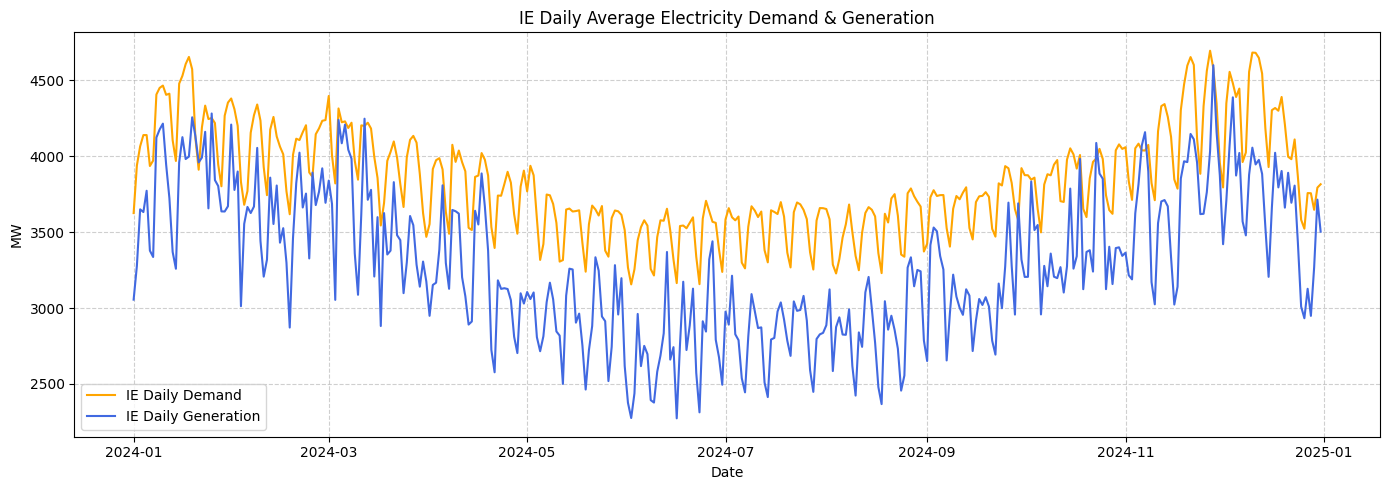

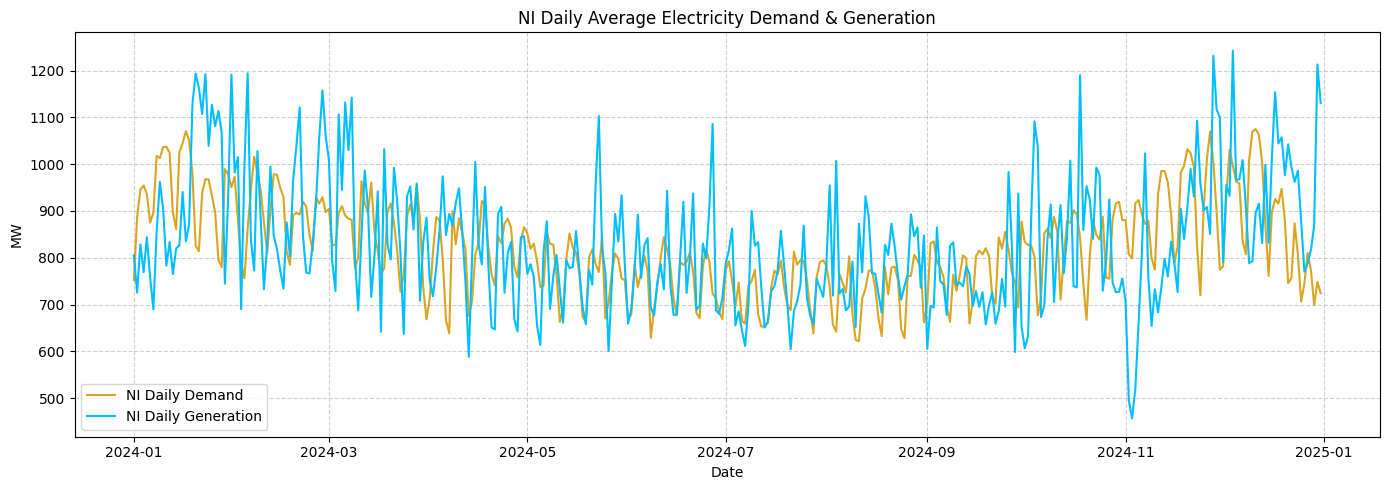

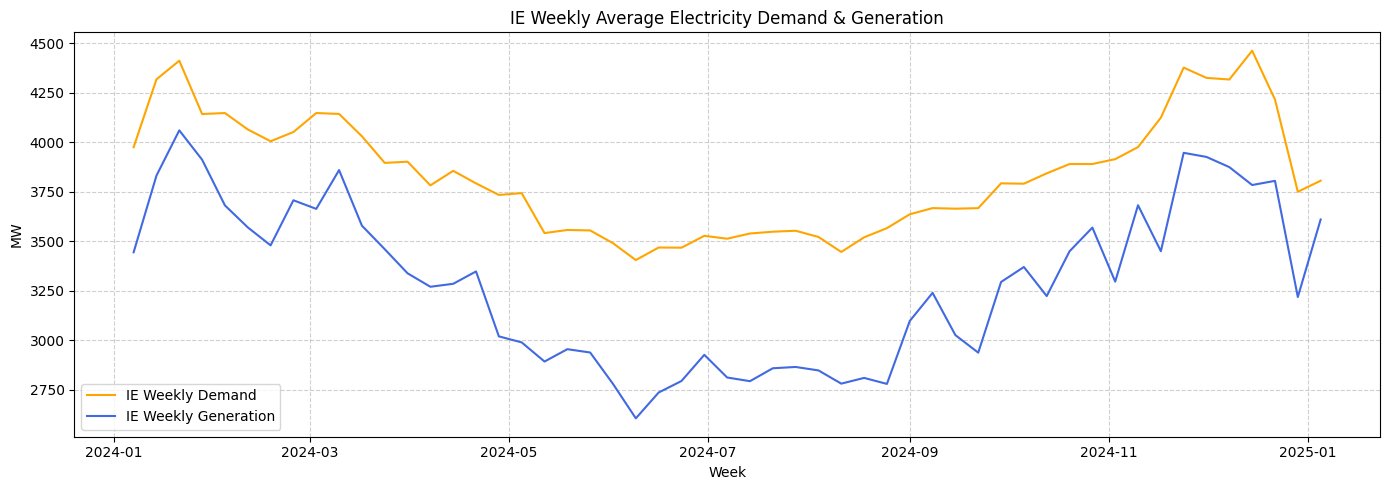

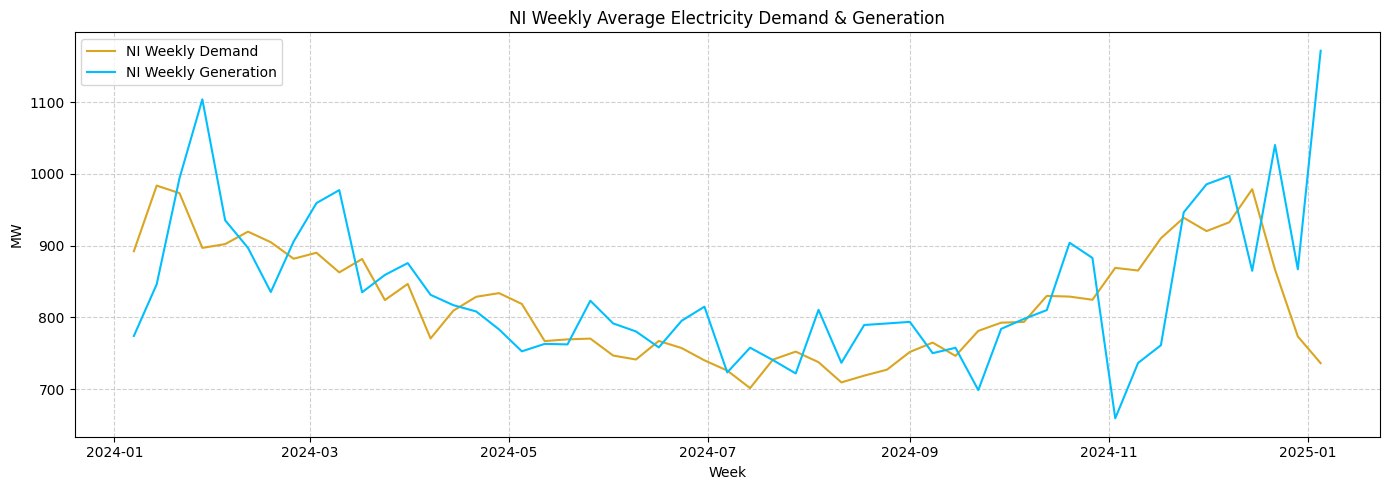

In [16]:
# Ensure DateTime index is set and sorted
data = data.sort_index()

# Select only numeric columns needed for averaging
numeric_cols = ['IE Demand', 'IE Generation', 'NI Demand', 'NI Generation']

# Compute daily averages
daily_avg = data[numeric_cols].resample('D').mean()

# Compute weekly averages
weekly_avg = data[numeric_cols].resample('W').mean()

# 1. IE Daily
plt.figure(figsize=(14,5))
plt.plot(daily_avg.index, daily_avg['IE Demand'], label='IE Daily Demand', color='orange')
plt.plot(daily_avg.index, daily_avg['IE Generation'], label='IE Daily Generation', color='royalblue')
plt.title("IE Daily Average Electricity Demand & Generation")
plt.xlabel("Date")
plt.ylabel("MW")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 2. NI Daily
plt.figure(figsize=(14,5))
plt.plot(daily_avg.index, daily_avg['NI Demand'], label='NI Daily Demand', color='goldenrod')
plt.plot(daily_avg.index, daily_avg['NI Generation'], label='NI Daily Generation', color='deepskyblue')
plt.title("NI Daily Average Electricity Demand & Generation")
plt.xlabel("Date")
plt.ylabel("MW")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 3. IE Weekly
plt.figure(figsize=(14,5))
plt.plot(weekly_avg.index, weekly_avg['IE Demand'], label='IE Weekly Demand', color='orange')
plt.plot(weekly_avg.index, weekly_avg['IE Generation'], label='IE Weekly Generation', color='royalblue')
plt.title("IE Weekly Average Electricity Demand & Generation")
plt.xlabel("Week")
plt.ylabel("MW")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 4. NI Weekly
plt.figure(figsize=(14,5))
plt.plot(weekly_avg.index, weekly_avg['NI Demand'], label='NI Weekly Demand', color='goldenrod')
plt.plot(weekly_avg.index, weekly_avg['NI Generation'], label='NI Weekly Generation', color='deepskyblue')
plt.title("NI Weekly Average Electricity Demand & Generation")
plt.xlabel("Week")
plt.ylabel("MW")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


From the analysis above we can observe the following trends:
 - Daily Demand vs Generation:
   - Both IE and NI show clear daily cycles with peaks during daytime hours and troughs at night.
   - Generation generally follows demand patterns but may lag slightly due to renewable sources like solar, this can also show that the lack of energy storage so generation has to follow demand.
   - In the ireland generation lags behind in generation in the winter months showing lower solar generation.
   - In the northern ireland data the generation is more consistent throughout the year due to the higher reliance on wind generation.
 - Weekly Demand vs Generation:
    - The graphs of generation and demand are more volatile a compared to the monthly graphs as they show more detail.
 - Peaks explanations:
      - The demand peaks are mainly during the winter months due to heating needs and shorter daylight hours.
      - The demand bottoms during the summer months when temperatures are milder and days are longer.
      - Generation peaks in spring and summer months due to increased solar generation and higher wind speeds.

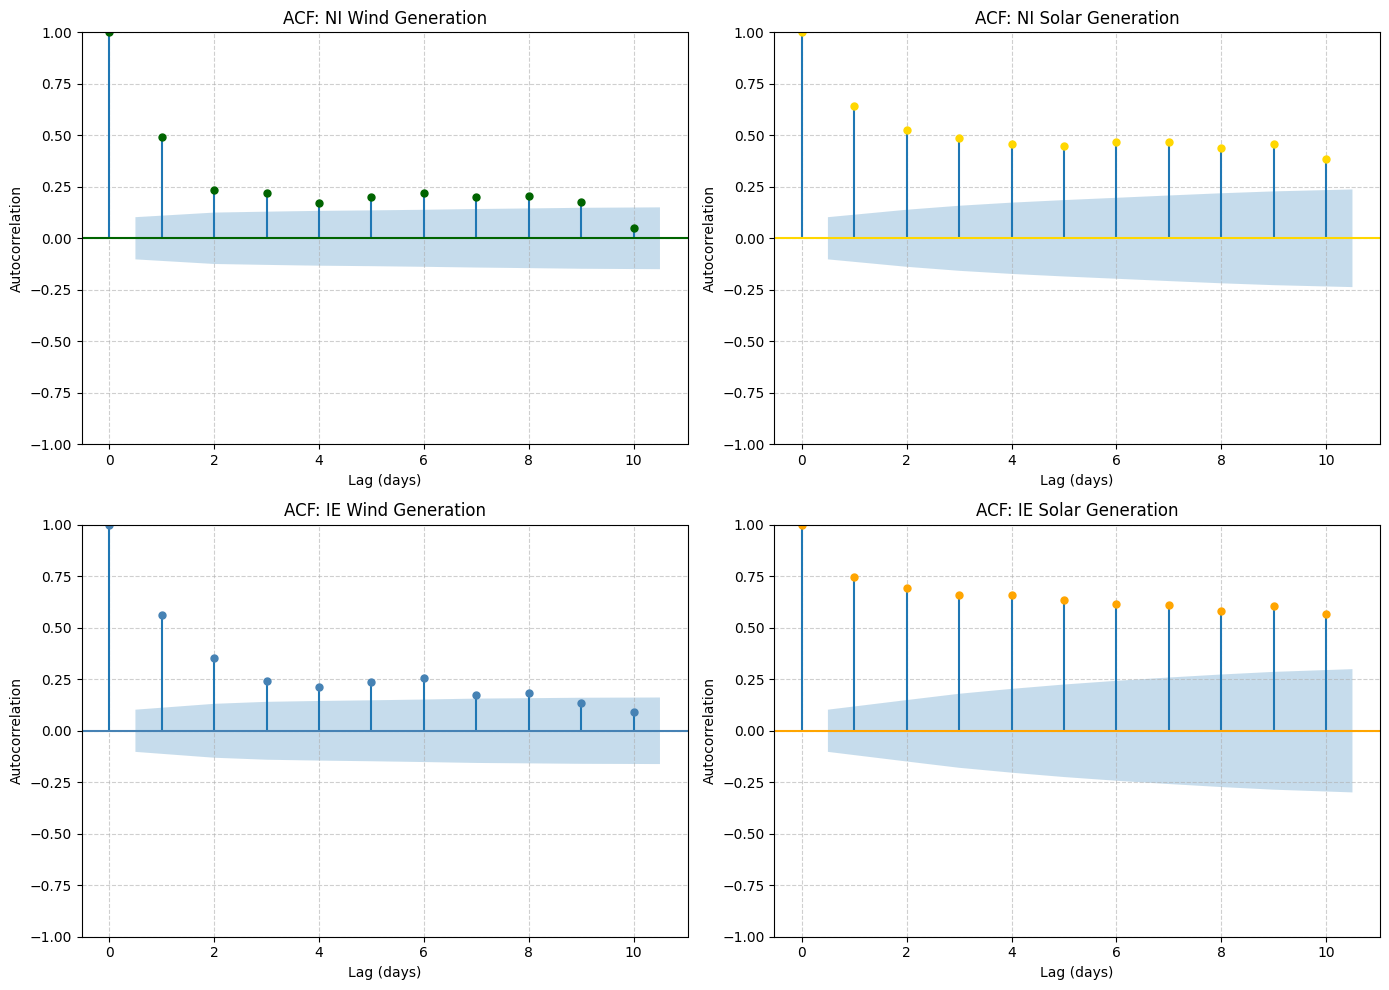

In [17]:
# Daily averages of renewable sources
renew_cols = ['NI Wind Generation', 'NI Solar Generation',
               'IE Wind Generation', 'IE Solar Generation']
daily_renew = data[renew_cols].resample('D').mean()

max_lag = 10  # 10-day lags

fig, axes = plt.subplots(2, 2, figsize=(14,10))

# NI Wind
plot_acf(daily_renew['NI Wind Generation'], lags=max_lag, ax=axes[0,0], color="darkgreen")
axes[0,0].set_title("ACF: NI Wind Generation")
axes[0,0].set_xlabel("Lag (days)")
axes[0,0].set_ylabel("Autocorrelation")
axes[0,0].grid(True, linestyle='--', alpha=0.6)

# NI Solar
plot_acf(daily_renew['NI Solar Generation'], lags=max_lag, ax=axes[0,1], color="gold")
axes[0,1].set_title("ACF: NI Solar Generation")
axes[0,1].set_xlabel("Lag (days)")
axes[0,1].set_ylabel("Autocorrelation")
axes[0,1].grid(True, linestyle='--', alpha=0.6)

# IE Wind
plot_acf(daily_renew['IE Wind Generation'], lags=max_lag, ax=axes[1,0], color="steelblue")
axes[1,0].set_title("ACF: IE Wind Generation")
axes[1,0].set_xlabel("Lag (days)")
axes[1,0].set_ylabel("Autocorrelation")
axes[1,0].grid(True, linestyle='--', alpha=0.6)

# IE Solar
plot_acf(daily_renew['IE Solar Generation'], lags=max_lag, ax=axes[1,1], color="orange")
axes[1,1].set_title("ACF: IE Solar Generation")
axes[1,1].set_xlabel("Lag (days)")
axes[1,1].set_ylabel("Autocorrelation")
axes[1,1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

The ACF plots show a strong correlation within the first one to three days, indicating that wind energy generation from one day is very similar to neighboring days. This means wind production on a given day can help predict wind output over the next few days. As the lag increases toward ten days, the correlation steadily decreases, showing that wind generation does not follow a weekly cycle. This can be explained by changing weather systems that change over shorter time periods.

Solar generation also shows positive autocorrelation ,it remains highly correlated even over multiple days because changes in daylight hours occur gradually over the season. Short-term weather influences such as cloud cover introduce some variability, but the dominant pattern in solar output due to slow seasonal shifts in day length as compared to weather changes.

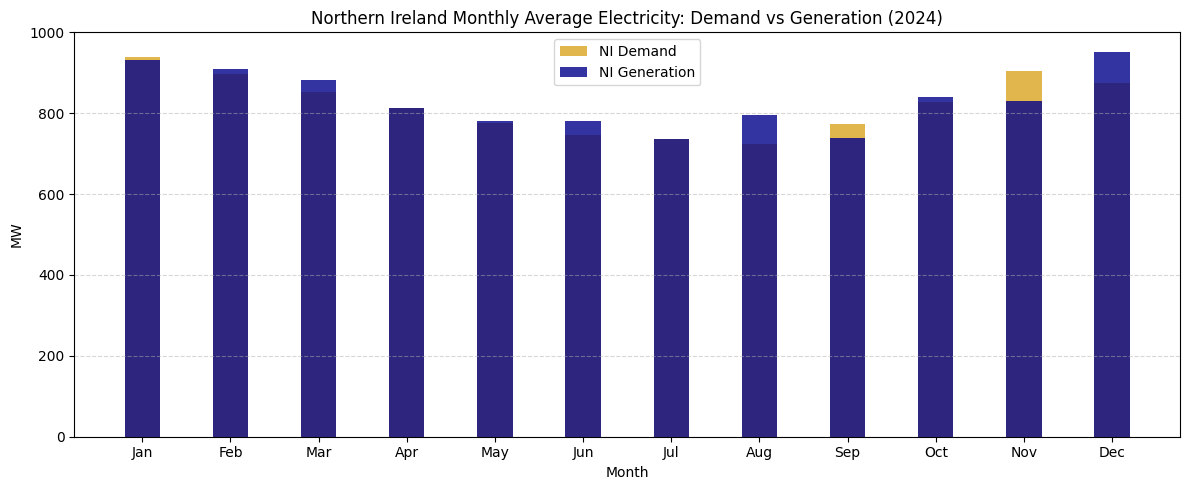

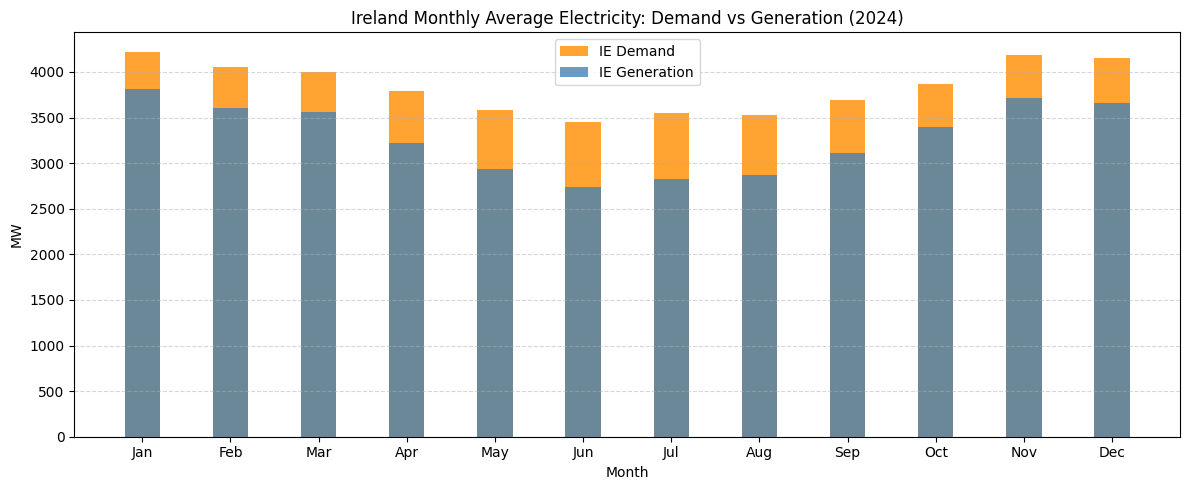

In [19]:
# Numeric columns
numeric_cols = ['NI Demand', 'NI Generation', 'IE Demand', 'IE Generation']

# Monthly averages
monthly_avg = data[numeric_cols].resample('ME').mean()

# Fix month labels to short names
month_labels = monthly_avg.index.strftime('%b')

# Northern Ireland Graph
plt.figure(figsize=(12,5))
plt.bar(month_labels, monthly_avg['NI Demand'], width=0.4, label='NI Demand', alpha=0.8, color='goldenrod')
plt.bar(month_labels, monthly_avg['NI Generation'], width=0.4, label='NI Generation', alpha=0.8, color='darkblue', bottom=None)
plt.title("Northern Ireland Monthly Average Electricity: Demand vs Generation (2024)")
plt.xlabel("Month")
plt.ylabel("MW")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Ireland Graph
plt.figure(figsize=(12,5))
plt.bar(month_labels, monthly_avg['IE Demand'], width=0.4, label='IE Demand', alpha=0.8, color='darkorange')
plt.bar(month_labels, monthly_avg['IE Generation'], width=0.4, label='IE Generation', alpha=0.8, color='steelblue', bottom=None)
plt.title("Ireland Monthly Average Electricity: Demand vs Generation (2024)")
plt.xlabel("Month")
plt.ylabel("MW")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Demands in both countries follows the same patterns as explained where demand peaks in winter and drops in summer.
Genration also follows the same patterns and in ireland the generation in lower than demand in the winter months showing that they need to import energy through this months.

The generation in northern ireland is higher than demand throughout the year showing that have a blend balance of energy sources like wind and solar to meet their demand and fit weather and seasonal changes.


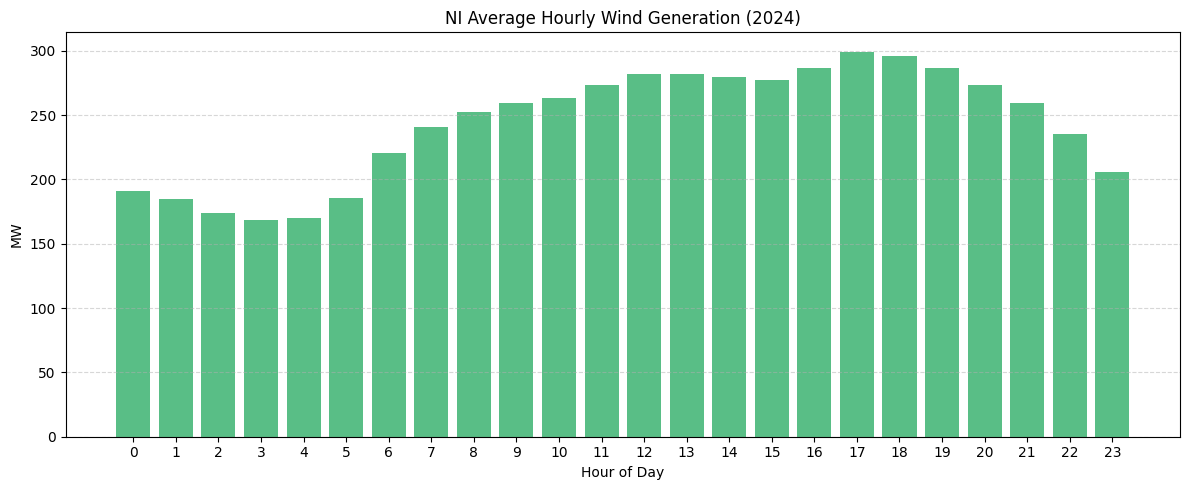

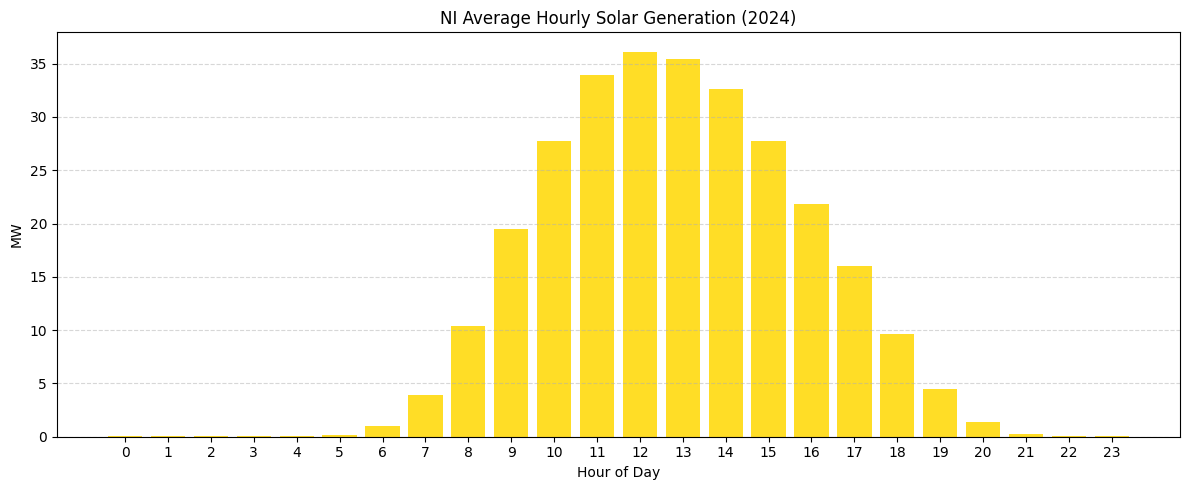

In [20]:
# Extract hour of the day
data['Hour'] = data.index.hour

# Compute average hourly values for NI wind & solar
hourly_avg = data.groupby('Hour')[['NI Wind Generation', 'NI Solar Generation']].mean()

# 1. NI Wind Generation Hourly Profile
plt.figure(figsize=(12,5))
plt.bar(hourly_avg.index, hourly_avg['NI Wind Generation'], color='mediumseagreen', alpha=0.85)
plt.title("NI Average Hourly Wind Generation (2024)")
plt.xlabel("Hour of Day")
plt.ylabel("MW")
plt.xticks(range(0,24))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 2. NI Solar Generation Hourly Profile
plt.figure(figsize=(12,5))
plt.bar(hourly_avg.index, hourly_avg['NI Solar Generation'], color='gold', alpha=0.85)
plt.title("NI Average Hourly Solar Generation (2024)")
plt.xlabel("Hour of Day")
plt.ylabel("MW")
plt.xticks(range(0,24))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

The plots show the average generation of solar and windpower:
The wind power generation follows more of a normal distribution with generation peaking around the evening hours and could be dues to pressure change due to temperature changes as the sun sets.
The solar generation follows a normal distribution over the daylight hours with the lowest being longer days as the season changes.

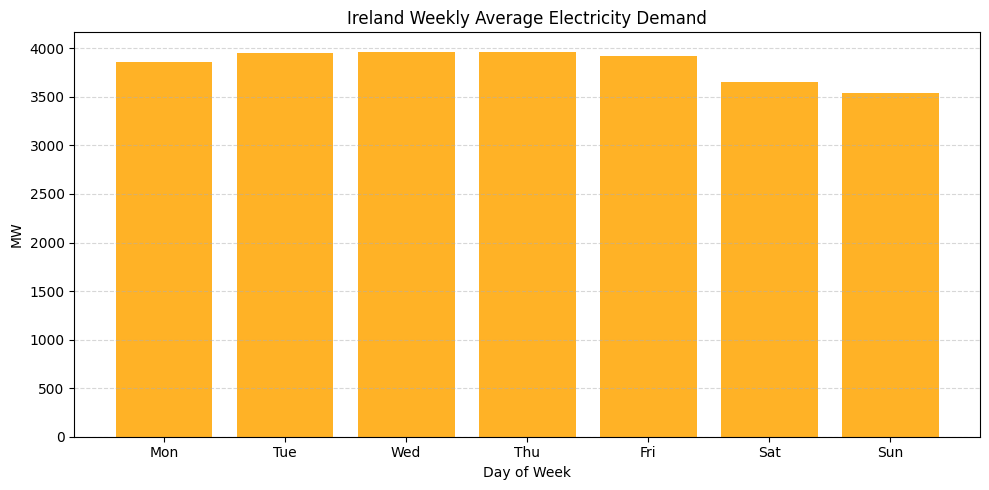

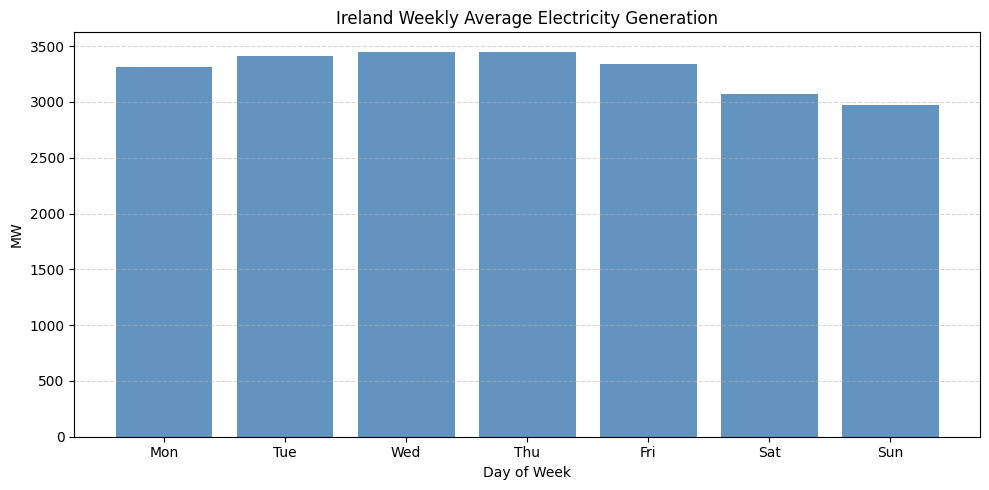

In [21]:
data['Weekday'] = data.index.weekday

# Group by weekday
weekday_avg = data.groupby('Weekday')[['IE Demand', 'IE Generation']].mean()

# Rename weekday numbers to names
weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
weekday_avg.index = weekday_labels

# 1. IE Demand by weekday
plt.figure(figsize=(10,5))
plt.bar(weekday_avg.index, weekday_avg['IE Demand'], color='orange', alpha=0.85)
plt.title("Ireland Weekly Average Electricity Demand")
plt.xlabel("Day of Week")
plt.ylabel("MW")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 2. IE Generation by weekday
plt.figure(figsize=(10,5))
plt.bar(weekday_avg.index, weekday_avg['IE Generation'], color='steelblue', alpha=0.85)
plt.title("Ireland Weekly Average Electricity Generation")
plt.xlabel("Day of Week")
plt.ylabel("MW")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

The weekday analysis shows an expected consumption patters as during the weekdays energy is consumed for industrial applications and other home devices
during the weekend the power consumption drops as industries are closed and people are out of their homes more often.

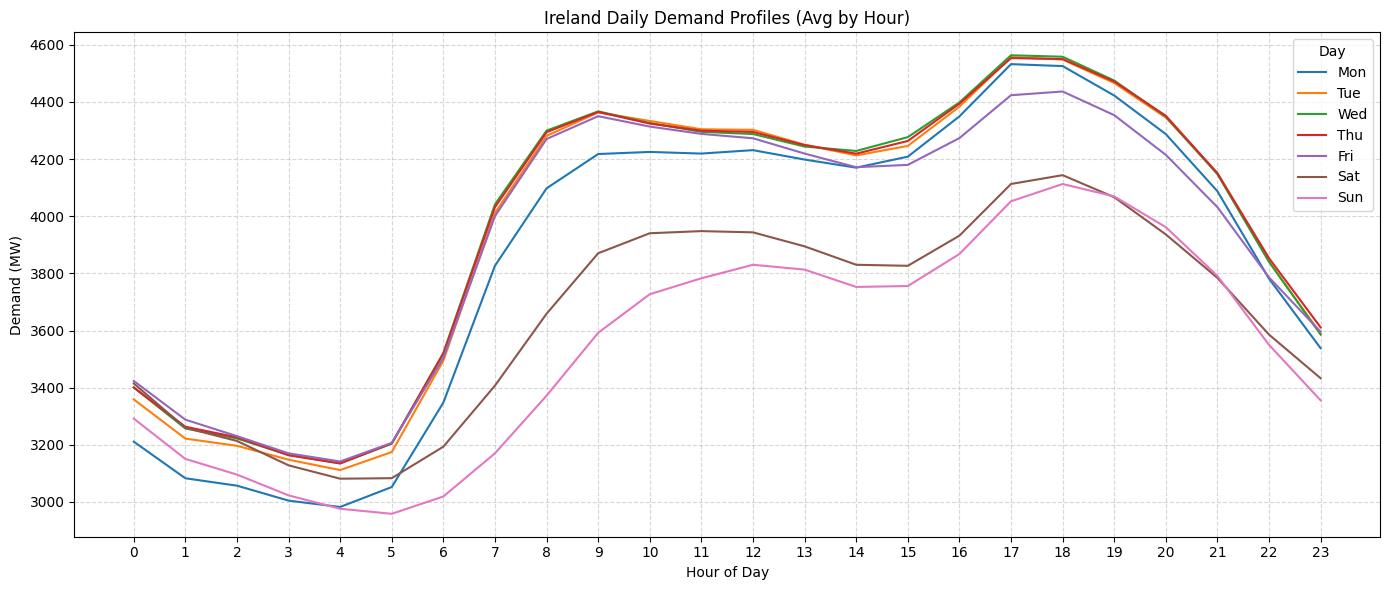

In [22]:
# Extract hour & weekday
data['Hour'] = data.index.hour
data['Weekday'] = data.index.weekday

# Group by weekday and hour
ni_profile = data.groupby(['Weekday', 'Hour'])['NI Demand'].mean().unstack(level=0)
ie_profile = data.groupby(['Weekday', 'Hour'])['IE Demand'].mean().unstack(level=0)

# Weekday labels for legend
weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# NI Plot
plt.figure(figsize=(14,6))
for i in range(7):
    plt.plot(ni_profile.index, ni_profile[i], label=weekday_labels[i])
plt.title("Northern Ireland Daily Demand Profiles (Avg by Hour)")
plt.xlabel("Hour of Day")
plt.ylabel("Demand (MW)")
plt.xticks(np.arange(0,24,1))
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Day")
plt.tight_layout()
plt.show()

# IE Plot
plt.figure(figsize=(14,6))
for i in range(7):
    plt.plot(ie_profile.index, ie_profile[i], label=weekday_labels[i])
plt.title("Ireland Daily Demand Profiles (Avg by Hour)")
plt.xlabel("Hour of Day")
plt.ylabel("Demand (MW)")
plt.xticks(np.arange(0,24,1))
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Day")
plt.tight_layout()
plt.show()

The plots show the energu demand as the day starts at midnight is lower as most activities are locked down and households mainly are asleep and most devices are in hibernation
When the morning comes the demand rises as people wake up and turn on home appliences and industrial processes are also done during the day heating an cooling in offices and transit as people go to the office
When the day sets in and most people are now settled the enegy demand now plateus upto evening hours during the drive home time and services in the evening like night lighting parties etc and it latter settles down as a bigger population goes to sleep

In [23]:
from scipy.stats import ttest_ind

# Create a Weekday column from the DatetimeIndex (Monday=0 to Sunday=6)
data['Weekday'] = data.index.weekday

# Weekend days: True for Saturday (5) and Sunday (6)
weekend = data['Weekday'].isin([5, 6])

# Weekday mask: True for Monday (0) through Friday (4)
weekday = data['Weekday'].isin([0, 1, 2, 3, 4])

# Dictionary to collect p-values for each tested column
results = {}

for col in ['IE Demand', 'NI Demand', 'IE Solar Generation', 'NI Solar Generation']:
    # Perform two-sample t-test comparing weekday vs weekend samples
    stat, p = ttest_ind(data.loc[weekday, col], data.loc[weekend, col], nan_policy='omit')
    # Store the rounded p-value
    results[col] = round(p, 4)

# results maps each column name to its p-value
results

{'IE Demand': np.float64(0.0),
 'NI Demand': np.float64(0.0),
 'IE Solar Generation': np.float64(0.4221),
 'NI Solar Generation': np.float64(0.574)}

The p-values is less than 0.05 meaning that the demand between weekdays and weekend due to industrial and commercial activities which are lower during the week ends
For solar generation the p value is greater than 0.05 showing that there is no significant diffrence in solar generation between week days and the week days

In [24]:
# Calculate wind penetration rates
data['NI Wind Penetration (%)'] = (data['NI Wind Generation'] / data['NI Demand']) * 100
data['IE Wind Penetration (%)'] = (data['IE Wind Generation'] / data['IE Demand']) * 100

# Plot distribution as a histogram
plt.figure(figsize=(12,6))
plt.hist(data['NI Wind Penetration (%)'], bins=40, alpha=0.6, label='NI Wind Penetration', color='green')
plt.hist(data['IE Wind Penetration (%)'], bins=40, alpha=0.6, label='IE Wind Penetration', color='blue')
plt.title("Distribution of Wind Penetration Rates (IE vs NI)")
plt.xlabel("Wind Penetration Rate (%)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

The distribution indicates that wind plays a significant role in both electricity systems, with penetration typically ranging from 20% to 40%. Ireland more frequently achieves high penetration levels (above 60%), reflecting its larger installed wind capacity and coastal exposure. Northern Ireland experiences more low-penetration periods, suggesting greater reliance on imports and conventional sources when wind output is weak. High variability, including rare cases where wind generation exceeds demand, highlights both the benefits and challenges of integrating large shares of variable renewable energy into the grid.